In [1]:
import sys
parentdir = 'C:\\Users\\anaxa\\Documents\\Projects\\Synthetic avatar\\BAMT'
sys.path.insert(0,parentdir) 

In [42]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans
import operator
from copy import copy
from sklearn.metrics import accuracy_score, mean_squared_error
from external.libpgm.sampleaggregator import SampleAggregator
from typing import Tuple
from dtaidistance import dtw
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from graph.precision_recall import precision_recall

In [3]:
def get_n_nearest(data, columns, corr = False, number_close=5):
    groups = []
    if corr:
        for c in columns:
            close_ind = data[c].sort_values(ascending=False).index.tolist()
            groups.append(close_ind[0:number_close+1])
    else:
        for c in columns:
            close_ind = data[c].sort_values().index.tolist()
            groups.append(close_ind[0:number_close+1])

    return groups

In [4]:
df = pd.read_csv('../data/hailfinder.csv')
df

,N0_7muVerMo,SubjVertMo,QGVertMotion,CombVerMo,AreaMeso_ALS,SatContMoist,RaoContMoist,CombMoisture,AreaMoDryAir,VISCloudCov,...,MeanRH,MidLLapse,MvmtFeatures,RHRatio,SfcWndShfDis,SynForcng,TempDis,WindAloft,WindFieldMt,WindFieldPln
0,WeakUp,StronUp,Neutral,WeakUp,WeakUp,Wet,VeryWet,VeryWet,VeryWet,PC,...,Average,CloseToDryAd,NoMajor,MoistMDryL,DryLine,LittleChange,None,LV,LVorOther,LV
1,Neutral,Neutral,Down,Neutral,Neutral,VeryWet,Neutral,Wet,Wet,Clear,...,VeryMoist,ModerateOrLe,NoMajor,Other,E_W_N,LittleChange,None,NWQuad,LVorOther,E_NE
2,WeakUp,Neutral,Neutral,WeakUp,WeakUp,VeryWet,Dry,VeryWet,VeryWet,PC,...,Average,ModerateOrLe,OtherRapid,MoistMDryL,DenvCyclone,LittleChange,Moving,SWQuad,Westerly,DenvCyclone
3,Neutral,Down,Neutral,Neutral,Neutral,Wet,Neutral,Neutral,Dry,Cloudy,...,Dry,Steep,NoMajor,MoistMDryL,DryLine,LittleChange,QStationary,LV,LVorOther,DenvCyclone
4,Down,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,PC,...,Average,Steep,StrongFront,Other,None,PosToNeg,None,SWQuad,Westerly,SEQuad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,StrongUp,Down,StrongUp,WeakUp,WeakUp,Neutral,Dry,Dry,Dry,PC,...,VeryMoist,ModerateOrLe,StrongFront,Other,E_W_N,LittleChange,None,LV,LVorOther,LV
9996,WeakUp,WeakUp,StrongUp,StrongUp,StrongUp,VeryWet,Dry,Wet,VeryWet,Clear,...,Dry,ModerateOrLe,OtherRapid,Other,E_W_N,NegToPos,None,SWQuad,Westerly,DenvCyclone
9997,Down,Neutral,Down,Neutral,Neutral,Neutral,Dry,Dry,Dry,Clear,...,Average,Steep,StrongFront,DryMMoistL,None,LittleChange,Other,NWQuad,LVorOther,LV
9998,Neutral,StronUp,WeakUp,WeakUp,WeakUp,Wet,Neutral,VeryWet,Wet,PC,...,Dry,ModerateOrLe,StrongFront,Other,DenvCyclone,LittleChange,None,SWQuad,LVorOther,DenvCyclone


In [5]:
df_coded, coder = code_categories(df, 'label', df.columns)
df_coded

,N0_7muVerMo,SubjVertMo,QGVertMotion,CombVerMo,AreaMeso_ALS,SatContMoist,RaoContMoist,CombMoisture,AreaMoDryAir,VISCloudCov,...,MeanRH,MidLLapse,MvmtFeatures,RHRatio,SfcWndShfDis,SynForcng,TempDis,WindAloft,WindFieldMt,WindFieldPln
0,3,2,1,3,3,3,2,2,2,2,...,0,0,1,1,1,0,1,1,0,2
1,1,1,0,1,1,2,1,3,3,0,...,2,1,1,2,2,0,1,2,0,1
2,3,1,1,3,3,2,0,2,2,2,...,0,1,2,1,0,0,0,3,1,0
3,1,0,1,1,1,3,1,1,0,1,...,1,2,1,1,1,0,3,1,0,0
4,0,1,1,1,1,1,1,1,1,2,...,0,2,3,2,5,2,1,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,2,3,3,1,0,0,0,2,...,2,1,3,2,2,0,1,1,0,2
9996,3,3,2,2,2,2,0,3,2,0,...,1,1,2,2,2,1,1,3,1,0
9997,0,1,0,1,1,1,0,0,0,0,...,0,2,3,0,5,0,2,2,0,2
9998,1,2,3,3,3,3,1,2,3,2,...,1,1,3,2,0,0,1,3,0,0


In [41]:
df_distance = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
df_distance.index = df.columns

In [9]:
for c1 in df.columns:
    for c2 in df.columns:
        dist = distance.euclidean(df_coded[c1].values, df_coded[c2].values)
        df_distance.loc[c1, c2] = dist

<AxesSubplot:>

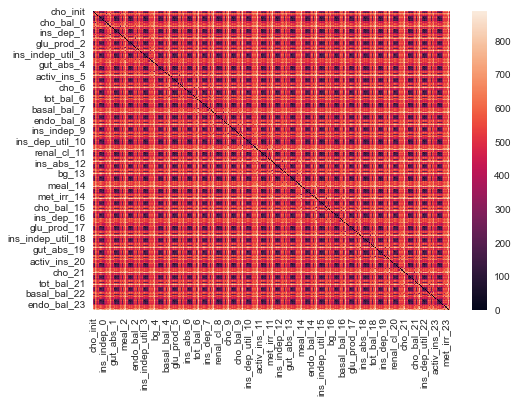

In [10]:
sns.heatmap(df_distance)

<AxesSubplot:>

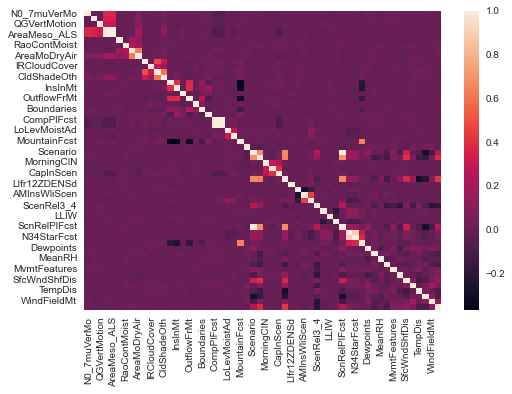

In [6]:
corr = df_coded.corr(method='spearman')
sns.heatmap(corr)

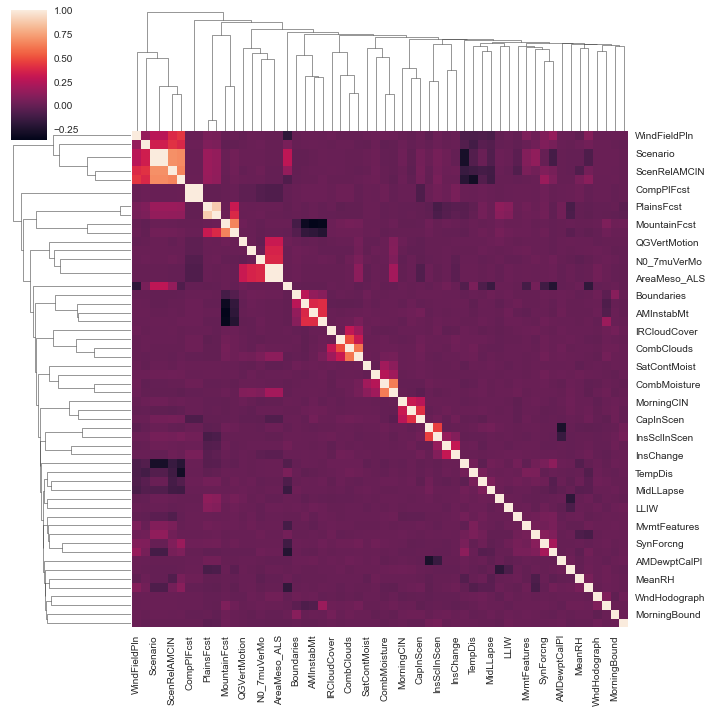

In [43]:
sns.clustermap(corr)

In [49]:
clustering = AgglomerativeClustering(n_clusters=5,affinity='precomputed', linkage = 'complete').fit(corr.values)

In [96]:
corr['label'] = clustering.labels_

In [97]:
for i in range(5):
    sub_df = corr.loc[corr['label'] == i]
    print(sub_df.shape[0])

11
13
17
7
8


In [53]:
sub_nets = []
for i in range(5):
    print(i)
    sub_columns = corr.loc[corr['label'] == i].columns.tolist()
    sub_columns.remove('label')
    sub_df = df_coded[sub_columns]
    nodes_type = get_nodes_type(sub_df)
    bn = structure_learning(sub_df, 'HC', nodes_type, 'K2')
    sub_nets.append(bn)



0
1
2
3
4


In [46]:
structure = pd.read_csv('../data/hailfinder_structure.csv')
structure

,arcs.from,arcs.to
0,N07muVerMo,CombVerMo
1,SubjVertMo,CombVerMo
2,QGVertMotion,CombVerMo
3,SatContMoist,CombMoisture
4,RaoContMoist,CombMoisture
...,...,...
61,N34StarFcst,R5Fcst
62,CapInScen,PlainsFcst
63,InsSclInScen,PlainsFcst
64,CurPropConv,PlainsFcst


In [47]:
structure_right = []
for i in structure.index:
    structure_right.append([structure.loc[i,'arcs.from'], structure.loc[i,'arcs.to']])

In [11]:
groups = get_n_nearest(corr, df.columns.tolist(), corr=True)

In [12]:
brave = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
brave.index = df.columns

In [13]:
for c1 in df.columns:
    for c2 in df.columns:
        a = 0
        b = 0
        c = 0
        d = 0
        if c1 != c2:
            for g in groups:
                if (c1 in g) & (c2 in g):
                    a += 1
                if (c1 in g) & (c2 not in g):
                    b += 1
                if (c1 not in g) & (c2 in g):
                    c += 1
                if (c1 not in g) & (c2 not in g):
                    d += 1
            br = (a*len(groups) + (a+c)*(a+b)) / ((math.sqrt((a + c + 0.00000001)*(b+d + 0.00000001))) * (math.sqrt((a+b + 0.00000001)*(c+d + 0.00000001))))
            brave.loc[c1,c2] = br




<AxesSubplot:>

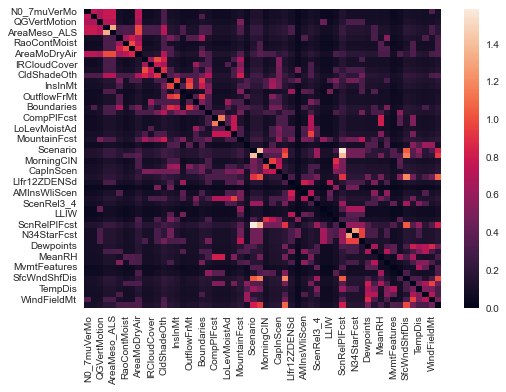

In [14]:
sns.heatmap(brave)

In [15]:
possible_edges = []
for c1 in df.columns:
    for c2 in df.columns:
        if brave.loc[c1, c2] > 0:
            possible_edges.append((c1, c2))


In [16]:
bn = structure_learning(df_coded, 'HC', get_nodes_type(df), 'K2', white_list=possible_edges)

In [27]:
brave_edgse = []
for e in bn['E']:
    brave_edgse.append((e[0], e[1]))

In [43]:
sparsebn_solution = pd.read_csv('hailfinder_solution.csv')
sparsebn_solution

,3 0
0,3 1
1,3 2
2,3 12
3,4 1
4,4 2
...,...
62,40 31
63,40 36
64,41 42
65,41 43


In [44]:
sparsebn_edges = []
for i in sparsebn_solution.index.tolist():
    c1 = int(sparsebn_solution.loc[i,'3 0'].split()[0])
    c2 = int(sparsebn_solution.loc[i,'3 0'].split()[1])
    sparsebn_edges.append([df.columns.tolist()[c1], df.columns.tolist()[c2]])

In [45]:
sparsebn_edges.append([df.columns.tolist()[3], df.columns.tolist()[0]])

In [31]:
G_right = nx.DiGraph()
for c in df.columns:
    G_right.add_node(c)
G_right.add_edges_from(structure_right)

In [32]:
G_sparse = nx.DiGraph()
for c in df.columns:
    G_sparse.add_node(c)
G_sparse.add_edges_from(sparsebn_edges)

In [36]:
G_brave = nx.DiGraph()
for c in df.columns:
    G_brave.add_node(c)
G_brave.add_edges_from(brave_edgse)

In [48]:
precision_recall(sparsebn_edges, structure_right)

{'AP': 0.6, 'AR': 0.62, 'AHP': 0.47, 'AHR': 0.48, 'SHD': 61}

In [49]:
precision_recall(brave_edgse, structure_right)

{'AP': 0.74, 'AR': 0.79, 'AHP': 0.64, 'AHR': 0.68, 'SHD': 39}